# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year].tsv``, ``positive_validation_after_{year}_pahse_4.tsv``, ``negative_prediction_after_{year}_phase_4.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [2]:
target_year = 2018
num_years_later = 2

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")

embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 278138 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2018.npy and ../data/embeddings_final/words_SG_upto2018.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,5.544086,3.900244,-5.571107,4.023921,-0.690671,5.045084,2.891233,5.713561,-3.167775,-5.355447,...,-1.178944,4.227701,-2.802720,-2.910172,-6.635629,1.170757,-3.134710,4.245651,1.295776,9.294687
patient,5.516126,4.064995,-7.371462,3.275807,-0.869867,5.350581,1.613561,5.720035,-2.368225,-5.069319,...,-0.528910,6.041771,-1.382483,-3.134443,-5.441506,1.143770,-3.800462,3.609437,1.312677,7.749951
meshd009369,5.514330,5.347095,-4.511601,4.540993,-0.171103,5.186315,1.921842,4.063017,-1.242869,-6.585094,...,-1.102929,3.709254,-3.064297,-1.693331,-4.602835,1.124388,-4.023498,5.386783,0.727251,8.287968
0,3.015314,4.347253,-5.247945,1.300399,-0.455834,6.122954,2.457049,5.309476,-3.489525,-6.540120,...,-0.589856,5.145733,-1.263917,-2.682243,-5.214277,1.378899,-4.782578,3.532945,1.179421,7.920753
study,5.344758,5.892451,-5.636815,2.876613,-0.623532,5.338674,2.060991,5.173227,-2.785678,-3.045907,...,-0.630316,3.953412,-1.198569,-2.071625,-4.895279,1.073490,-2.490999,3.854250,0.936672,7.703007
1,3.740305,4.762334,-5.183757,1.510455,-0.324129,5.206121,1.944532,4.878118,-3.192989,-4.791201,...,-0.950221,5.208447,-2.343183,-2.127656,-5.012542,1.198391,-3.963571,3.774423,1.682876,8.378260
use,3.858829,5.224904,-5.747828,2.767147,-0.708477,5.809757,2.388821,4.325610,-3.059532,-4.986820,...,-0.618118,2.951320,-1.668634,-5.023390,-3.281270,1.128616,-4.117539,3.972474,0.927381,7.407399
treatment,4.320082,3.552744,-4.864308,3.393475,-0.724211,5.659916,1.947094,7.243562,-2.682269,-6.335474,...,-0.241835,4.782804,-1.093247,-3.258259,-4.739478,1.255569,-3.629974,4.610537,1.030638,9.041243
2,3.333377,4.558437,-5.366470,1.589037,-0.440878,5.951880,1.651716,5.093137,-3.016540,-5.232817,...,-0.936136,5.502128,-2.022234,-2.331195,-4.670235,1.276601,-3.627492,3.394002,1.605149,8.407037
expression,3.801692,4.275945,-5.162064,3.334162,-0.515905,6.005465,3.258746,6.466090,-2.133804,-4.737078,...,-1.461477,6.418555,-1.717424,-3.600635,-4.764203,1.493333,-4.182888,3.568821,0.907861,8.706170


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  278138


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples =  "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd002289,ncbigene1956
1,meshd002289,ncbigene2064
2,meshd002289,ncbigene2066
3,meshd002294,ncbigene1956
4,meshd002294,ncbigene2064


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

465 positive examples
278138 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 381 kinase-cancer difference vectors
[INFO]	Initial data: 465 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 1 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd002289,-3.239107,0.245929,0.773560,-0.640676,-0.338023,2.571537,-0.563340,-0.889164,-0.138696,-1.561695,...,0.417250,-2.413453,-1.180655,1.232238,-1.317104,0.139265,-0.744309,-0.338702,1.198285,0.441039
ncbigene2064-meshd002289,-2.644751,1.072389,2.272508,-0.638248,-0.582121,2.391233,-0.514758,-1.444349,-0.777111,-0.603968,...,0.177549,-2.599428,-1.195050,1.754695,-0.067019,-0.032097,-1.102636,-0.208887,1.208584,0.368526
ncbigene2066-meshd002289,-2.854317,1.005730,2.450376,-1.697786,-0.335900,1.708226,-0.735822,-1.554486,0.694125,-0.592814,...,0.812708,-2.721399,-0.857599,0.350145,0.330992,0.366557,0.333867,-1.765329,1.707907,-0.539112
ncbigene1956-meshd002294,-1.568446,-0.135508,0.370564,-0.160120,-0.438520,-0.734251,-0.426531,-1.338006,-1.577734,-0.632871,...,-0.208203,-0.976566,0.474222,3.569532,-1.439013,0.573701,-0.006658,2.071012,0.058532,-0.190969
ncbigene2064-meshd002294,-0.974090,0.690951,1.869513,-0.157692,-0.682618,-0.914555,-0.377949,-1.893190,-2.216149,0.324855,...,-0.447903,-1.162541,0.459828,4.091989,-0.188928,0.402338,-0.364985,2.200826,0.068831,-0.263482


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

381 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd002528,ncbigene701
1,meshd015448,ncbigene167359
2,meshd018273,ncbigene25778
3,meshd017624,ncbigene4915
4,meshd000708,ncbigene9031


In [12]:
print("%d negative examples" % len(negative_df))

3870 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 3448 kinase-cancer difference vectors
[INFO]	Initial data: 3870 examples
[INFO]	Could not identify 19 gene ids
[INFO]	Could not identify 49 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene701-meshd002528,0.132108,-0.859751,-1.938617,-1.452199,-0.071170,-0.147918,0.631920,0.740513,0.577740,-0.010729,...,1.400252,0.476850,-0.792183,0.441526,-0.636994,0.183716,-1.728993,0.393222,-0.643963,0.703292
ncbigene167359-meshd015448,-1.106279,-1.559231,1.350318,-2.465781,0.753055,-1.606594,-1.534526,-2.676971,0.721525,0.835316,...,-0.234491,-1.118340,0.953623,1.716789,1.436547,-1.238240,0.277096,-0.413652,-1.896281,-1.969659
ncbigene25778-meshd018273,-1.622217,-1.839933,2.137858,-1.910166,0.365323,-3.212757,-1.186276,-2.565975,1.753278,2.305100,...,0.649474,-2.237638,-0.213367,0.633854,2.842243,-0.954022,0.837302,-2.375111,-0.919293,-3.944873
ncbigene4915-meshd017624,0.431446,1.836073,-0.429946,0.298738,-0.870770,2.374847,1.507470,0.561355,-0.476045,0.058009,...,-0.722900,0.734215,0.473654,-0.236799,-1.238034,1.259726,-0.071226,2.025267,-0.630039,2.736523
ncbigene9031-meshd000708,-1.880805,-0.787471,2.491363,-1.609367,0.279923,-2.622877,-0.616660,-2.861605,1.146481,2.907672,...,-0.286243,-1.748682,1.217145,1.583542,2.326174,-2.004098,1.228525,-2.262105,-0.851176,-2.499246


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=381) and negative (n=3448) to the combined dataframe (3829)


In [16]:
X_train.values

array([[-3.239107  ,  0.24592948,  0.7735596 , ..., -0.33870173,
         1.1982846 ,  0.4410391 ],
       [-2.6447506 ,  1.0723889 ,  2.2725081 , ..., -0.2088871 ,
         1.2085836 ,  0.36852598],
       [-2.8543174 ,  1.0057304 ,  2.450376  , ..., -1.7653294 ,
         1.7079072 , -0.5391116 ],
       ...,
       [-1.3129675 , -1.9669542 ,  0.6484952 , ..., -2.1083946 ,
        -1.3034548 , -1.4845533 ],
       [-1.9387784 , -0.38206983,  1.6048176 , ..., -1.5274274 ,
        -1.6000339 , -2.013514  ],
       [-0.6047056 , -2.3209436 ,  2.8532453 , ..., -1.2384319 ,
        -0.6884183 , -1.5144429 ]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6581221  0.03804127 0.03115635]


Text(0, 0.5, 'PC 2 (3.80%)')

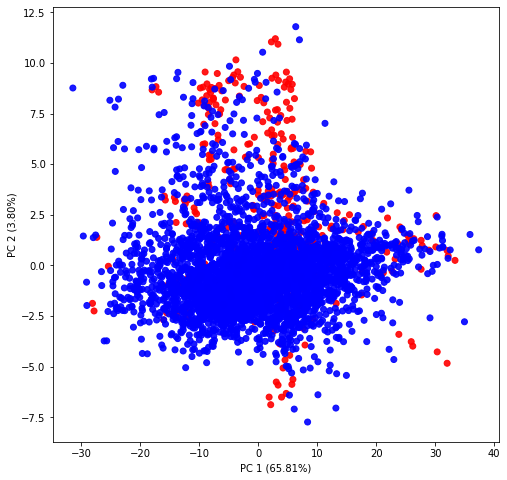

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3829 samples in 0.003s...
[t-SNE] Computed neighbors for 3829 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3829
[t-SNE] Computed conditional probabilities for sample 2000 / 3829
[t-SNE] Computed conditional probabilities for sample 3000 / 3829
[t-SNE] Computed conditional probabilities for sample 3829 / 3829
[t-SNE] Mean sigma: 0.883779
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.609169
[t-SNE] KL divergence after 300 iterations: 1.398993
t-SNE done! Time elapsed: 11.978730916976929 seconds


Text(0, 0.5, 'tsne-2d-two')

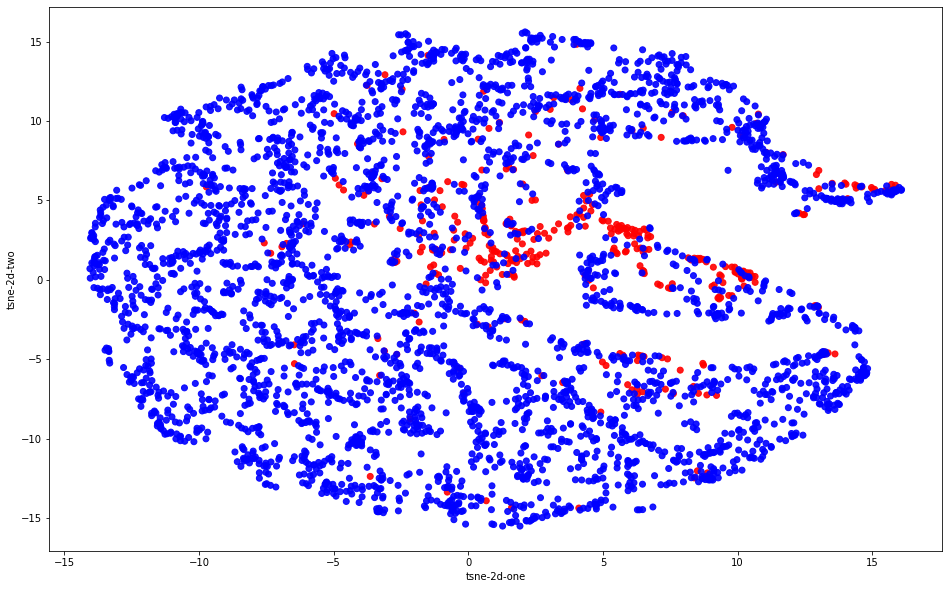

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (3829, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 381, number of negative examples: 3448, Y_train.shape: (3829,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}_phase4.tsv".format(num_years_later, target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd055756,ncbigene83942
1,meshd016609,ncbigene83942
2,meshd015473,ncbigene3716
3,meshd015473,ncbigene3717
4,meshd016609,ncbigene3480


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 20 kinase-cancer difference vectors
[INFO]	Initial data: 20 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 0 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene83942-meshd055756,-2.081746,-1.432057,3.022330,-2.282027,1.052863,-4.678148,-1.066057,-3.760872,0.075450,2.595383,...,0.520010,-2.883442,0.095775,3.142288,3.906394,-0.538007,1.899446,-2.759342,-1.239305,-4.970540
ncbigene83942-meshd016609,-3.084584,-1.712599,3.810392,-1.653372,0.857748,-2.536948,-1.598967,-4.279492,0.558786,3.747996,...,0.956577,-5.040376,1.532355,1.915747,3.640717,-0.810565,1.581748,-3.002199,-0.373235,-4.779491
ncbigene3716-meshd015473,-0.050961,0.582866,-0.251933,-1.992285,0.459602,-0.725106,0.334615,-3.033716,0.253639,0.007665,...,0.828290,-0.636821,-0.469846,3.602160,0.389759,0.579510,0.973500,1.991740,-1.441961,0.132860
ncbigene3717-meshd015473,0.183742,0.262335,-0.782928,-0.820749,0.305601,-1.168795,0.171297,-2.028431,0.644271,-0.881013,...,0.785995,-0.632943,-0.569466,3.234891,0.134090,0.632629,0.614864,1.730896,-0.949859,-0.024743
ncbigene3480-meshd016609,-0.762371,1.309856,0.389412,0.933498,-0.026039,1.140189,0.666521,-1.658859,-0.982173,-0.085358,...,0.038427,-2.918410,1.669420,1.208197,0.800853,-0.045137,-1.235114,0.140122,0.489634,0.950754


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_{}_years_after_{}_phase4.tsv".format(num_years_later, target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd006106,ncbigene673
1,meshd018222,ncbigene79858
2,meshd051677,ncbigene11011
3,meshd004379,ncbigene2868
4,meshd016403,ncbigene91461


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 3469 kinase-cancer difference vectors
[INFO]	Initial data: 3870 examples
[INFO]	Could not identify 19 gene ids
[INFO]	Could not identify 49 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene673-meshd006106,0.107049,-1.228067,-2.767703,-0.586601,-0.038399,-0.353981,0.620405,-0.056046,1.558500,-3.481677,...,1.188271,2.115548,-1.457100,2.438203,-0.767285,-0.092342,-1.076821,2.041617,-1.277249,0.000292
ncbigene79858-meshd018222,0.249375,0.209723,-0.058301,-0.033572,0.452136,0.186658,-0.243724,-0.033299,-0.261302,-0.017994,...,0.279025,-0.099176,-0.446658,-0.045899,-0.169296,0.038705,0.118337,0.138535,-0.065731,-0.182684
ncbigene11011-meshd051677,-1.000266,-1.111866,1.066612,-2.123817,-0.200069,-1.547371,-1.021487,-1.263460,0.142573,2.491218,...,0.876068,-1.968299,-0.244343,2.672982,1.208990,-1.319285,1.222313,-1.060602,-1.478670,-1.934183
ncbigene2868-meshd004379,-0.144938,-0.764347,0.915257,-0.944462,-0.784597,-0.679157,0.011372,-0.704737,0.269736,0.626117,...,0.422820,-0.774104,0.084585,-0.207260,2.021343,-0.718046,-0.567889,-0.454964,0.031000,0.415321
ncbigene91461-meshd016403,-2.336828,-1.302109,2.500160,-1.942321,1.046679,-2.440703,-1.260149,-3.442325,0.775651,2.195867,...,-0.071349,-2.123402,0.819713,1.894511,2.785852,-0.327762,0.523662,-2.281573,-1.695289,-4.008245


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later, target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path = "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later, target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)